Non-Stacked


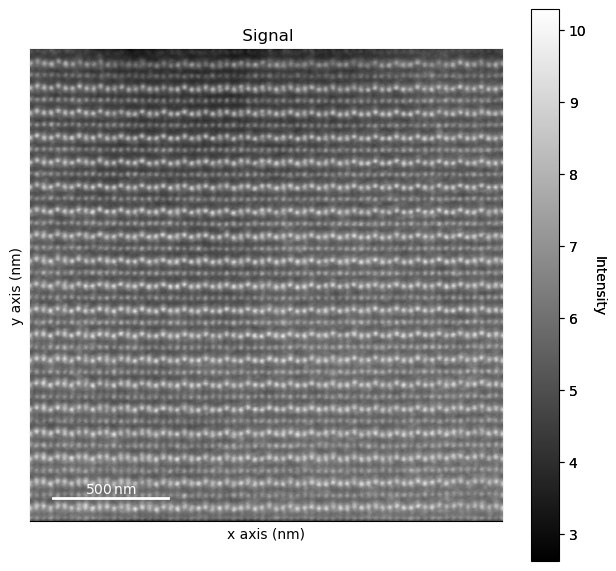

In [1]:
import skimage
import matplotlib.pyplot as plt
import hyperspy.api as hs
import sys
sys.path.append('../..')
import util.crop

stack_num = 0 # The index of stacked image

# Change the name of s_load to load different plots.
# Note that some datasets are in stacks and their data will be 3-dimension,
# where the first dimention is the index of a single stacked image. We want to
# look at one image each of the time, so for those stacked images, please change
# stack_num to view different images.

# Load one file at a time.
# These commented files are some that I want think could be reevaluated later for references.
s_load = hs.load('../../data/images/Jaume LFO/HAADF_Buena.dm3')

if len(s_load.data.shape) == 2: # Non-stacked
    print("Non-Stacked")
    s = s_load
else: # Stacked, where s_load.data.shape = 3
    print("Stacked")
    s = s_load.inav[stack_num]

# Plot the image in pixels. We can plot in nanometers by simply doing s.plot().
import copy
s_copy = copy.deepcopy(s)
for ax in s_copy.axes_manager.signal_axes:
    ax.scale = 1.0
    ax.offset = 0.0

plt.close()
s_copy.plot()

In [2]:
import scipy.signal
import numpy as np

left_bound = 40 # TUNE THIS
right_bound = 2040 # TUNE THIS
start_pixel = 40 # TUNE THIS
end_pixel = 2040 # TUNE THIS
# window_height_nm = None

crop = util.crop.Crop(s, left_bound, right_bound, start_pixel, end_pixel)

In [3]:
crop.build_grid_dict()
crop.get_atom_positions()
# crop.refine_atom_positions()

crop.get_nn_intensities()
crop.get_nn_displacements()
crop.get_atom_types()

In [4]:
from sklearn.decomposition import PCA

intensity_vectors = []

for patch in crop.grid.values():
    # Filter for 'Lu' and ensure data exists
    if patch.nn_intensity_differences is not None and patch.atom_type == 'Lu':
        intensity_vectors.append(patch.nn_intensity_differences)

X = np.array(intensity_vectors)

Explained Variance Ratio per component: [0.4514158  0.33451755 0.12810839 0.08595826]
Cumulative Variance: [0.4514158  0.78593335 0.91404174 1.        ]


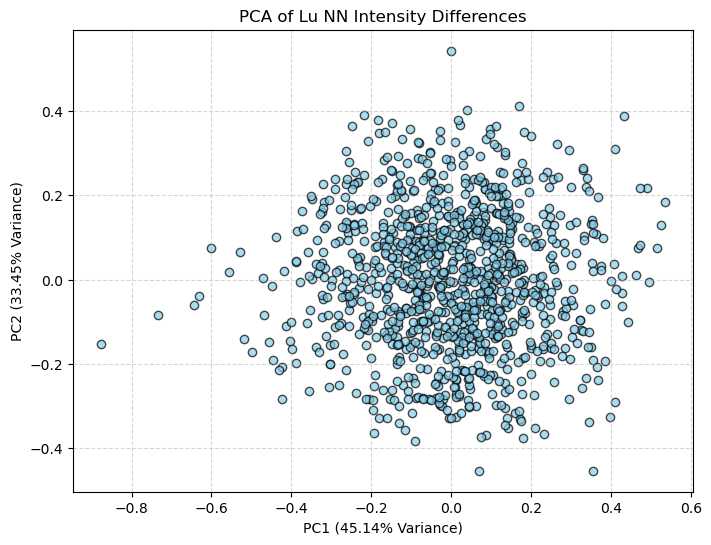

In [12]:
pca = PCA(n_components=None) 
X_pca = pca.fit_transform(X)

print("Explained Variance Ratio per component:", pca.explained_variance_ratio_)
print("Cumulative Variance:", np.cumsum(pca.explained_variance_ratio_))

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.7, color='skyblue', edgecolor='black')
plt.title('PCA of Lu NN Intensity Differences')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} Variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} Variance)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

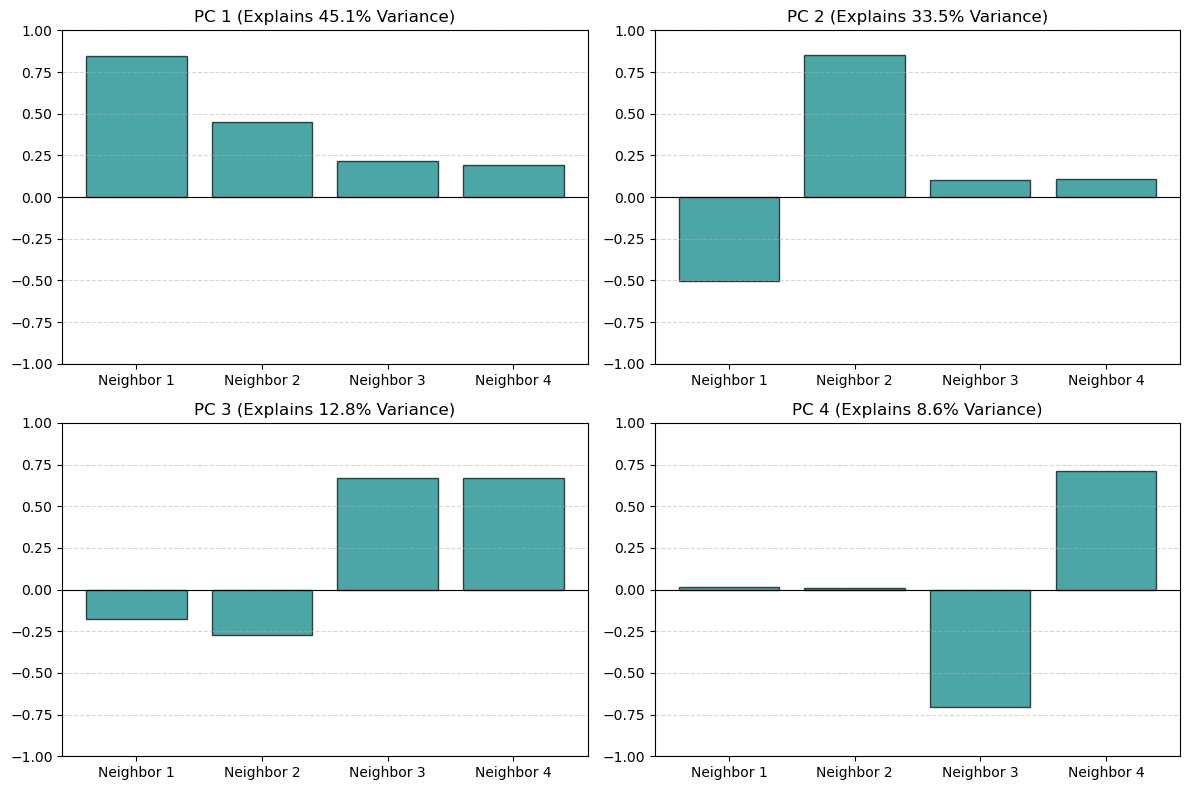

Component Loadings (Rows=PC, Cols=Neighbor):
[[ 0.8463429   0.44926497  0.21411951  0.18978283]
 [-0.50247877  0.85154723  0.104678    0.10688738]
 [-0.17601126 -0.27015787  0.66892999  0.66975177]
 [ 0.01545399  0.00655885 -0.70407956  0.70992262]]


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 1. Setup Data (Same as before)
lu_vectors = []
for patch in crop.grid.values():
    if patch.nn_intensity_differences is not None and patch.atom_type == 'Lu':
        lu_vectors.append(patch.nn_intensity_differences)

X = np.array(lu_vectors)

# 2. Run PCA with all 4 components
pca = PCA(n_components=4)
pca.fit(X)

# 3. Plot the Loadings (The "Recipe" for each Component)
feature_names = ['Neighbor 1', 'Neighbor 2', 'Neighbor 3', 'Neighbor 4']
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, ax in enumerate(axes):
    # pca.components_[i] contains the 4 weights for PC_i
    weights = pca.components_[i]
    
    # Create bar chart
    ax.bar(feature_names, weights, color='teal', edgecolor='black', alpha=0.7)
    
    # Formatting
    variance = pca.explained_variance_ratio_[i]
    ax.set_title(f'PC {i+1} (Explains {variance:.1%} Variance)')
    ax.set_ylim(-1.0, 1.0) # Eigenvectors are normalized, this keeps scale consistent
    ax.axhline(0, color='black', linewidth=0.8)
    ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Optional: Print exact values if you need to debug specific numbers
print("Component Loadings (Rows=PC, Cols=Neighbor):")
print(pca.components_)